In [1]:
!wget https://raw.githubusercontent.com/HSE-CROSS-LING-DL/cma/master/data/trk-uncovered-train-transliterated.csv -O train.csv
!wget https://raw.githubusercontent.com/HSE-CROSS-LING-DL/cma/master/data/trk-uncovered-dev-transliterated.csv -O dev.csv
!wget https://raw.githubusercontent.com/HSE-CROSS-LING-DL/cma/master/data/trk-uncovered-test-transliterated.csv -O test.csv

--2019-12-20 09:30:59--  https://raw.githubusercontent.com/HSE-CROSS-LING-DL/cma/master/data/trk-uncovered-train-transliterated.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5650505 (5.4M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   5.39M  --.-KB/s    in 0.08s   

2019-12-20 09:30:59 (64.2 MB/s) - ‘train.csv’ saved [5650505/5650505]

--2019-12-20 09:31:01--  https://raw.githubusercontent.com/HSE-CROSS-LING-DL/cma/master/data/trk-uncovered-dev-transliterated.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response...

In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

In [0]:
data = pd.read_csv('train.csv')
dev = pd.read_csv('dev.csv')
test = pd.read_csv('test.csv')

In [4]:
data.shape, dev.shape, test.shape

((79228, 5), (1245, 5), (12926, 5))

In [5]:
data = data.dropna()
data = data.reset_index(drop=True)
data.shape

(79228, 5)

In [6]:
test = test.dropna()
test = test.reset_index(drop=True)
test.shape

(12926, 5)

In [7]:
dev = dev.dropna()
dev = dev.reset_index(drop=True)
dev.shape

(1245, 5)

In [8]:
data['pos'].value_counts() * 100 / data.shape[0]

NOUN    53.789064
VERB    40.141112
ADJ      5.231736
ADV      0.838088
Name: pos, dtype: float64

In [9]:
test['pos'].value_counts() * 100 / test.shape[0]

NOUN    68.280984
VERB    27.587808
ADJ      3.496828
ADV      0.634380
Name: pos, dtype: float64

In [10]:
data.head()

,lang,word,lemma,pos,morph
0,tat,казак,казак,NOUN,Case=Nom
1,tur,мuамеле,мuамеле,NOUN,Case=Nom
2,tat,заманы,заман,NOUN,"Case=Nom|Number[psor]=Sing,Plur|Person[psor]=3"
3,tur,конuт,конuт,NOUN,Case=Nom
4,tur,корuмасы,корu,VERB,"Case=Nom|Number[psor]=Sing,Plur|Person[psor]=3..."


In [11]:
dev.head()

,lang,word,lemma,pos,morph
0,crh,егленcелер,егленcе,NOUN,Case=Nom|Number=Plur
1,crh,сüргüнликниң,сüргüнлик,NOUN,Case=Gen
2,crh,монархийада,монархийа,NOUN,Case=Loc
3,crh,кöстергенлери,кöстер,VERB,"Case=Nom|Number=Plur|Number[psor]=Sing,Plur|Pe..."
4,crh,öксüз,öксüз,NOUN,Case=Nom


POS-теги:

In [0]:
pos_mapper = {pos: n for n, pos in enumerate(data.pos.unique())}
data['pos_num'] = data.pos.map(pos_mapper)
test['pos_num'] = test.pos.map(pos_mapper)
dev['pos_num'] = dev.pos.map(pos_mapper)

In [13]:
test.head()

,lang,word,lemma,pos,morph,pos_num
0,krc,джыл,джыл,NOUN,Case=Nom,0
1,krc,эм,эм,ADV,_,3
2,krc,эм,эм,NOUN,Case=Nom,0
3,krc,джылны,джыл,NOUN,Case=Acc,0
4,krc,джылны,джыл,NOUN,Case=Gen,0


In [0]:
def multihot(words, pos):
  multihot_dict = {}
  for word, pos_num in tqdm(zip(words, pos)):
    if word in multihot_dict:
      multihot_dict[word][pos_num] = 1
    else:
      multihot_dict[word] = torch.Tensor(np.zeros(4))
      multihot_dict[word][pos_num] = 1

  return multihot_dict

In [15]:
multihot_train = multihot(data.word, data.pos_num)

79228it [00:01, 69265.55it/s]


In [16]:
multihot_test = multihot(test.word, test.pos_num)

12926it [00:00, 65699.60it/s]


In [17]:
multihot_dev = multihot(dev.word, dev.pos_num)

1245it [00:00, 42003.09it/s]


Data Loader

In [0]:
from torch.utils.data import Dataset, DataLoader

In [19]:
char2index = {'PAD': 0}
MAX_LEN = 0
lengths = []

for word in tqdm(data.word):
  l = len(word)
  lengths.append(l)
  
  for char in word:
    if char not in char2index:
      char2index[char] = len(char2index)

100%|██████████| 79228/79228 [00:00<00:00, 478025.10it/s]


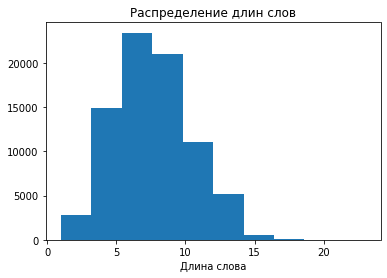

In [20]:
from matplotlib import pyplot as plt

plt.title('Распределение длин слов')
plt.xlabel('Длина слова')
plt.hist(lengths)
plt.show()

In [21]:
lengths = np.array([lengths])
np.percentile(lengths, q=95)

12.0

In [0]:
class LoadData(Dataset):
    
    def __init__(self, x_data, y_data, char2index=char2index, sequence_length=12,\
                 pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = y_data

        self.char2index = char2index

        self.sequence_length = sequence_length
        self.pad_token = pad_token
        self.pad_index = self.char2index[self.pad_token]

        self.load(x_data, verbose=verbose)

    def preprocess(self, word):
      return [c for c in word]

    def indexing(self, chars):
        return [self.char2index[char] for char in chars if char in self.char2index]

    def load(self, data, verbose=True):
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        
        for word in data_iterator:
            chars = self.preprocess(word)
            indexed_chars = self.indexing(chars)
            self.x_data.append(indexed_chars)

    def padding(self, sequence):
        if len(sequence) > self.sequence_length:
          sequence = sequence[:self.sequence_length]
        elif len(sequence) < self.sequence_length:
          sequence = sequence + [self.pad_index] * (self.sequence_length - len(sequence))
        return sequence

    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        y = self.y_data[idx]
        
        return x, y

In [23]:
train_dataset = LoadData(list(multihot_train.keys()), list(multihot_train.values()))

Loading data: 100%|██████████| 43886/43886 [00:00<00:00, 310829.79it/s]


In [24]:
test_dataset = LoadData(list(multihot_test.keys()), list(multihot_test.values()))

Loading data: 100%|██████████| 8768/8768 [00:00<00:00, 226735.91it/s]


In [25]:
dev_dataset = LoadData(list(multihot_dev.keys()), list(multihot_dev.values()))

Loading data: 100%|██████████| 999/999 [00:00<00:00, 141219.03it/s]


In [0]:
train_data_loader = DataLoader(train_dataset, batch_size=64)
test_data_loader = DataLoader(test_dataset, batch_size=64)
dev_data_loader = DataLoader(dev_dataset, batch_size=64)

Веса классов

In [27]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', np.unique(data.pos_num), data.pos_num)
weights = torch.FloatTensor(weights)
weights

tensor([ 0.4648,  0.6228,  4.7785, 29.8298])

# Модель

In [0]:
from torch import nn

In [0]:
class POSTagger(nn.Module):

  def __init__(self, embedding_dim=64, vocab_size=len(char2index), hidden_dim=64, 
               ngrams=[2,3,4], seq_len=12, n_classes=4, keep_proba=0.4):

    super().__init__()

    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim

    self.dropout = nn.Dropout(p=keep_proba)

    self.embedding_layer = nn.Embedding(num_embeddings=self.vocab_size, \
                                        embedding_dim=self.embedding_dim)
    
    self.lstm_layer = nn.LSTM(self.embedding_dim, self.hidden_dim, batch_first=True, bidirectional=True)

    # Attention layers
    self.key = nn.Linear(in_features=self.hidden_dim*2, out_features=self.hidden_dim*2)
    self.query = nn.Linear(in_features=self.hidden_dim*2, out_features=self.hidden_dim*2)
    self.value = nn.Linear(in_features=self.hidden_dim*2, out_features=self.hidden_dim*2)

    self.convs = nn.ModuleList([nn.Conv1d(in_channels=self.hidden_dim*2, 
                                          out_channels=self.hidden_dim, 
                                          kernel_size=n) for n in ngrams])
    
    self.pooling = nn.ModuleList([nn.MaxPool1d(kernel_size=seq_len-n+1) for n in ngrams])
    self.linear = nn.Linear(in_features=len(ngrams) * self.hidden_dim, out_features=n_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.embedding_layer(x)
    lstm_x, mem = self.lstm_layer(x)

    x_key = self.key(lstm_x)
    x_query = self.query(lstm_x)
    x_value = self.value(lstm_x)

    attention_scores = torch.bmm(x_query, x_key.transpose(1, 2)) / self.hidden_dim
    attention_distribution = torch.nn.functional.softmax(attention_scores, dim=2)

    x_attn = torch.bmm(attention_distribution, x_value)
    x_transposed = x_attn.transpose(1, 2)

    conved = [conv(x_transposed) for conv in self.convs]
    pooled = [pool(conv).squeeze(-1) for pool, conv in zip(self.pooling, conved)]
    cat = self.dropout(torch.cat(pooled, 1))
    out = self.linear(cat)

    return self.sigmoid(out)

In [0]:
def score_model(preds, targets, thresholds=[0.4]*4):
  precisions, recalls, fscores = [], [], []
  for pred, target in zip(preds, targets):
    tp, fp, tn, fn = [], [], [], []
    for class_idx in range(len(pred)):

      class_is_predicted = pred[class_idx] >= thresholds[class_idx]
      class_is_required = bool(target[class_idx])
      if class_is_predicted:
        if class_is_required:
          tp.append(class_idx)
        else:
          fp.append(class_idx)
      else:
        if not class_is_required:
          tn.append(class_idx)
        else:
          fn.append(class_idx)

    precision = len(tp) / (len(tp) + len(fp)) if any((tp, fp)) else 0
    recall = len(tp) / (len(tp) + len(fn)) if any((tp, fn)) else 0
    fscore = 2 * precision* recall / (precision + recall) if any((precision, recall)) else 0

    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)

  return np.mean(precisions), np.mean(recalls), np.mean(fscores)

In [0]:
model = POSTagger()

criterion = nn.BCELoss(weight=weights)
optimizer = torch.optim.Adam(params=model.parameters())

In [35]:
epochs = 15
losses = []
best_test_loss = 10.

for n_epoch in range(epochs):
    precisions, recalls, fscores = [], [], []
    train_losses, test_losses = [], []
    
    progress_bar = tqdm(total=len(train_data_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_data_loader:     
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()

    for x, y in dev_data_loader:
  
      with torch.no_grad():
            
        pred = model(x)
        loss = criterion(pred, y)

        test_losses.append(loss.item())

        precision, recall, fscore = score_model(pred, y)

        precisions.append(precision)
        recalls.append(recall)
        fscores.append(fscore)

    mean_test_loss = np.mean(test_losses)

    precision = np.mean(precisions)
    recall = np.mean(recalls)
    fscore = np.mean(fscores)

    print()
    print('Losses: train - {:.3f}, dev - {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    print('Dev: precision - {:.3f}, recall - {:.3f}, fscore - {:.3f}'.format(precision, recall, fscore))

    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 2:   0%|          | 192/43886 [00:00<00:31, 1401.04it/s, train_loss=0.996]


Losses: train - 1.052, dev - 0.764
Dev: precision - 0.746, recall - 0.786, fscore - 0.756


Epoch 3:   0%|          | 192/43886 [00:00<00:31, 1395.01it/s, train_loss=0.883]


Losses: train - 0.902, dev - 0.716
Dev: precision - 0.790, recall - 0.834, fscore - 0.802


Epoch 4:   0%|          | 192/43886 [00:00<00:32, 1358.09it/s, train_loss=0.821]


Losses: train - 0.833, dev - 0.701
Dev: precision - 0.807, recall - 0.860, fscore - 0.822


Epoch 5:   0%|          | 192/43886 [00:00<00:30, 1420.28it/s, train_loss=0.764]


Losses: train - 0.778, dev - 0.698
Dev: precision - 0.816, recall - 0.864, fscore - 0.829


Epoch 5: 100%|██████████| 43886/43886 [00:31<00:00, 1372.30it/s, train_loss=0.719]



Losses: train - 0.731, dev - 0.699
Dev: precision - 0.819, recall - 0.873, fscore - 0.834
Early stopping


# test

In [36]:
precisions, recalls, fscores = [], [], []
for x, y in test_data_loader:
  with torch.no_grad():        
        pred = model(x)

        precision, recall, fscore = score_model(pred, y)

        precisions.append(precision)
        recalls.append(recall)
        fscores.append(fscore)

precision = np.mean(precisions)
recall = np.mean(recalls)
fscore = np.mean(fscores)

print('Test: precision - {:.3f}, recall - {:.3f}, fscore - {:.3f}'.format(precision, recall, fscore))

Test: precision - 0.778, recall - 0.844, fscore - 0.798
